In [1]:
!pip install eli5

In [2]:
import shap

In [3]:
import pandas as pd
import numpy as np
import shap
import numpy.random as rnd
import matplotlib.pyplot as plt
import category_encoders as ce
import eli5
from eli5 import show_weights
from eli5.sklearn import PermutationImportance
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler, \
                                    OneHotEncoder, \
                                    LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV


In [4]:
pd.set_option('display.max_columns', None)

In [5]:
features = pd.read_csv('./train_features.csv', header=0)
features.head()

,id,member_id,loan_amnt,funded_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,annual_inc_joint,dti_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,disbursement_method
0,43373,NaN,12000,12000,36 months,16.02%,422.01,C,C5,Driver,4 years,MORTGAGE,81000.0,NaN,NaN,debt_consolidation,Debt consolidation,280xx,NC,12.76,0,Dec-2005,1,48.0,NaN,7,0,4912,23.5%,15,w,0,48.0,Individual,NaN,NaN,0,0,174783,1,2,0,4,13.0,33668,82.0,2,5,2962,63.0,20900,1,1,2,9,24969.0,588.0,89.3,0,0,145.0,23,1,1,1,8.0,NaN,1.0,NaN,2,2,2,2,2,9,4,5,2,7,0.0,0,0,2,92.9,100.0,0,0,206618,38580,5500,40863,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash
1,24414,NaN,6300,6300,36 months,14.07%,215.54,C,C3,GMP Lead,4 years,RENT,39000.0,NaN,NaN,debt_consolidation,Debt consolidation,920xx,CA,21.42,0,Mar-2012,1,NaN,NaN,10,0,11876,59.4%,12,w,0,NaN,Individual,NaN,NaN,0,0,31046,0,1,0,2,14.0,19170,83.0,3,8,5153,72.0,20000,1,0,1,10,3105.0,6877.0,59.3,0,0,17.0,72,8,8,0,8.0,NaN,6.0,NaN,0,6,7,7,8,2,9,10,7,10,0.0,0,0,3,100.0,42.9,0,0,43140,31046,16900,23140,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash
2,46723,NaN,4500,4500,36 months,7.21%,139.38,A,A3,Accounts,3 years,RENT,78000.0,NaN,NaN,debt_consolidation,Debt consolidation,906xx,CA,2.17,0,May-2000,2,NaN,NaN,13,0,1715,5.2%,19,w,0,NaN,Individual,NaN,NaN,0,0,35329,0,8,1,2,10.0,33614,106.0,1,1,1196,54.0,33300,4,0,3,3,2718.0,21585.0,7.4,0,0,166.0,218,10,10,0,31.0,NaN,1.0,NaN,0,3,3,3,4,13,5,6,3,13,0.0,0,0,2,100.0,0.0,0,0,65092,35329,23300,31792,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash
3,24878,NaN,12000,12000,36 months,9.44%,384.06,B,B1,Client Processing Associate,10+ years,MORTGAGE,62000.0,NaN,NaN,debt_consolidation,Debt consolidation,441xx,OH,13.76,0,Feb-2003,0,NaN,NaN,22,0,9404,16.3%,33,w,0,NaN,Individual,NaN,NaN,0,0,75160,4,1,0,2,13.0,17123,67.0,6,9,6898,32.0,57600,3,1,2,12,3579.0,33602.0,17.0,0,0,162.0,179,1,1,1,1.0,NaN,5.0,NaN,0,1,3,9,13,7,20,25,3,22,0.0,0,0,7,100.0,0.0,0,0,133065,26527,40500,25465,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash
4,39038,NaN,12000,12000,36 months,22.35%,460.47,D,D5,Construction Operator,10+ years,MORTGAGE,70000.0,NaN,NaN,debt_consolidation,Debt consolidation,751xx,TX,14.04,4,Nov-2001,2,13.0,NaN,18,0,17895,24.2%,45,w,0,13.0,Individual,NaN,NaN,0,7218,113702,9,2,2,4,6.0,16711,68.0,9,10,5373,35.0,73900,3,6,3,14,6317.0,32863.0,24.1,0,0,159.0,201,0,0,1,0.0,62.0,3.0,62.0,6,9,11,11,14,22,15,20,11,18,0.0,0,2,11,82.2,9.1,0,0,192842,34606,43300,24499,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash


In [6]:
target = pd.read_csv('./train_labels.csv', header=0)
target.head()

,id,charged_off
0,43373,0
1,24414,0
2,46723,0
3,24878,0
4,39038,0


In [7]:
train = features.merge(target)
print('train.shape:', train.shape)
train.head()

train.shape: (37745, 104)


,id,member_id,loan_amnt,funded_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,annual_inc_joint,dti_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,disbursement_method,charged_off
0,43373,NaN,12000,12000,36 months,16.02%,422.01,C,C5,Driver,4 years,MORTGAGE,81000.0,NaN,NaN,debt_consolidation,Debt consolidation,280xx,NC,12.76,0,Dec-2005,1,48.0,NaN,7,0,4912,23.5%,15,w,0,48.0,Individual,NaN,NaN,0,0,174783,1,2,0,4,13.0,33668,82.0,2,5,2962,63.0,20900,1,1,2,9,24969.0,588.0,89.3,0,0,145.0,23,1,1,1,8.0,NaN,1.0,NaN,2,2,2,2,2,9,4,5,2,7,0.0,0,0,2,92.9,100.0,0,0,206618,38580,5500,40863,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,0
1,24414,NaN,6300,6300,36 months,14.07%,215.54,C,C3,GMP Lead,4 years,RENT,39000.0,NaN,NaN,debt_consolidation,Debt consolidation,920xx,CA,21.42,0,Mar-2012,1,NaN,NaN,10,0,11876,59.4%,12,w,0,NaN,Individual,NaN,NaN,0,0,31046,0,1,0,2,14.0,19170,83.0,3,8,5153,72.0,20000,1,0,1,10,3105.0,6877.0,59.3,0,0,17.0,72,8,8,0,8.0,NaN,6.0,NaN,0,6,7,7,8,2,9,10,7,10,0.0,0,0,3,100.0,42.9,0,0,43140,31046,16900,23140,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,0
2,46723,NaN,4500,4500,36 months,7.21%,139.38,A,A3,Accounts,3 years,RENT,78000.0,NaN,NaN,debt_consolidation,Debt consolidation,906xx,CA,2.17,0,May-2000,2,NaN,NaN,13,0,1715,5.2%,19,w,0,NaN,Individual,NaN,NaN,0,0,35329,0,8,1,2,10.0,33614,106.0,1,1,1196,54.0,33300,4,0,3,3,2718.0,21585.0,7.4,0,0,166.0,218,10,10,0,31.0,NaN,1.0,NaN,0,3,3,3,4,13,5,6,3,13,0.0,0,0,2,100.0,0.0,0,0,65092,35329,23300,31792,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,0
3,24878,NaN,12000,12000,36 months,9.44%,384.06,B,B1,Client Processing Associate,10+ years,MORTGAGE,62000.0,NaN,NaN,debt_consolidation,Debt consolidation,441xx,OH,13.76,0,Feb-2003,0,NaN,NaN,22,0,9404,16.3%,33,w,0,NaN,Individual,NaN,NaN,0,0,75160,4,1,0,2,13.0,17123,67.0,6,9,6898,32.0,57600,3,1,2,12,3579.0,33602.0,17.0,0,0,162.0,179,1,1,1,1.0,NaN,5.0,NaN,0,1,3,9,13,7,20,25,3,22,0.0,0,0,7,100.0,0.0,0,0,133065,26527,40500,25465,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,0
4,39038,NaN,12000,12000,36 months,22.35%,460.47,D,D5,Construction Operator,10+ years,MORTGAGE,70000.0,NaN,NaN,debt_consolidation,Debt consolidation,751xx,TX,14.04,4,Nov-2001,2,13.0,NaN,18,0,17895,24.2%,45,w,0,13.0,Individual,NaN,NaN,0,7218,113702,9,2,2,4,6.0,16711,68.0,9,10,5373,35.0,73900,3,6,3,14,6317.0,32863.0,24.1,0,0,159.0,201,0,0,1,0.0,62.0,3.0,62.0,6,9,11,11,14,22,15,20,11,18,0.0,0,2,11,82.2,9.1,0,0,192842,34606,43300,24499,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,0


### Handle missing values

In [8]:
nulls = pd.DataFrame(data=train.isnull().sum(), columns=['count'])
nulls_sorted = nulls.sort_values(by='count', ascending=False)
nulls_sorted.head(50)

,count
desc,37745
member_id,37745
url,37745
sec_app_mths_since_last_major_derog,36077
sec_app_revol_util,33106
sec_app_open_acc,33007
annual_inc_joint,33007
dti_joint,33007
revol_bal_joint,33007
sec_app_earliest_cr_line,33007


In [9]:
train = train.loc[:, train.isnull().sum(axis=0) < 1000]
train.shape

(37745, 76)

In [10]:
train.head()

,id,loan_amnt,funded_amnt,term,int_rate,installment,grade,sub_grade,home_ownership,annual_inc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,total_bal_il,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,disbursement_method,charged_off
0,43373,12000,12000,36 months,16.02%,422.01,C,C5,MORTGAGE,81000.0,debt_consolidation,Debt consolidation,280xx,NC,12.76,0,Dec-2005,1,7,0,4912,23.5%,15,w,0,Individual,0,0,174783,1,2,0,4,33668,2,5,2962,63.0,20900,1,1,2,9,24969.0,588.0,89.3,0,0,23,1,1,1,8.0,2,2,2,2,2,9,4,5,2,7,0,0,2,92.9,100.0,0,0,206618,38580,5500,40863,Cash,0
1,24414,6300,6300,36 months,14.07%,215.54,C,C3,RENT,39000.0,debt_consolidation,Debt consolidation,920xx,CA,21.42,0,Mar-2012,1,10,0,11876,59.4%,12,w,0,Individual,0,0,31046,0,1,0,2,19170,3,8,5153,72.0,20000,1,0,1,10,3105.0,6877.0,59.3,0,0,72,8,8,0,8.0,0,6,7,7,8,2,9,10,7,10,0,0,3,100.0,42.9,0,0,43140,31046,16900,23140,Cash,0
2,46723,4500,4500,36 months,7.21%,139.38,A,A3,RENT,78000.0,debt_consolidation,Debt consolidation,906xx,CA,2.17,0,May-2000,2,13,0,1715,5.2%,19,w,0,Individual,0,0,35329,0,8,1,2,33614,1,1,1196,54.0,33300,4,0,3,3,2718.0,21585.0,7.4,0,0,218,10,10,0,31.0,0,3,3,3,4,13,5,6,3,13,0,0,2,100.0,0.0,0,0,65092,35329,23300,31792,Cash,0
3,24878,12000,12000,36 months,9.44%,384.06,B,B1,MORTGAGE,62000.0,debt_consolidation,Debt consolidation,441xx,OH,13.76,0,Feb-2003,0,22,0,9404,16.3%,33,w,0,Individual,0,0,75160,4,1,0,2,17123,6,9,6898,32.0,57600,3,1,2,12,3579.0,33602.0,17.0,0,0,179,1,1,1,1.0,0,1,3,9,13,7,20,25,3,22,0,0,7,100.0,0.0,0,0,133065,26527,40500,25465,Cash,0
4,39038,12000,12000,36 months,22.35%,460.47,D,D5,MORTGAGE,70000.0,debt_consolidation,Debt consolidation,751xx,TX,14.04,4,Nov-2001,2,18,0,17895,24.2%,45,w,0,Individual,0,7218,113702,9,2,2,4,16711,9,10,5373,35.0,73900,3,6,3,14,6317.0,32863.0,24.1,0,0,201,0,0,1,0.0,6,9,11,11,14,22,15,20,11,18,0,2,11,82.2,9.1,0,0,192842,34606,43300,24499,Cash,0


### Wrangle features

In [11]:
def wrangle(d):
    def sub_grade_to_float(x):
        return float(ord(x[0]) - 64) + float(x[1:]) / 10
    
    df = d.copy()
    df.sub_grade = df.sub_grade.apply(sub_grade_to_float)
    df.int_rate = df.int_rate.apply(lambda x: float(x.strip()[:-1]))
    df.dti = df.dti.fillna(df.dti.median())
    df.all_util = df.all_util.fillna(df.all_util.median())
    df.avg_cur_bal = df.avg_cur_bal.fillna(df.avg_cur_bal.median())
    df.zip_code = df.zip_code.apply(lambda x: int(x[:3]))
    
    # A nan value is considered a float, so if there are nan values
    # in any feature that is not float, you have to process those
    # values specially, before you can process the non-nan values.
    # Instead, you can create a loop and an if statement to process
    # each value depending on it's type.
    res = []
    for i in range(len(df.revol_util)):
        if isinstance(df.revol_util[i], float):
            res.append(0.0)
        else:
            res.append(float(df.revol_util[i].strip('%')))
    df.revol_util = res
    df.application_type = (df.application_type == 'Joint App').astype(int)
    
    return df

In [12]:
dfx = train.copy()

In [13]:
df = wrangle(train)

In [14]:
use_columns = ['funded_amnt', 'int_rate',
                   'sub_grade', 'annual_inc', 'delinq_2yrs', 'all_util', 
                   'avg_cur_bal', 'chargeoff_within_12_mths',
                   'collections_12_mths_ex_med', 'dti', 'application_type',
                   'home_ownership', 'zip_code', 'inq_last_6mths',
                   'pub_rec', 'revol_bal', 'revol_util', 'tot_coll_amt',
                   'tot_cur_bal',
                   'charged_off']
df = df.loc[:, use_columns].copy()
df.head()

,funded_amnt,int_rate,sub_grade,annual_inc,delinq_2yrs,all_util,avg_cur_bal,chargeoff_within_12_mths,collections_12_mths_ex_med,dti,application_type,home_ownership,zip_code,inq_last_6mths,pub_rec,revol_bal,revol_util,tot_coll_amt,tot_cur_bal,charged_off
0,12000,16.02,3.5,81000.0,0,63.0,24969.0,0,0,12.76,0,MORTGAGE,280,1,0,4912,23.5,0,174783,0
1,6300,14.07,3.3,39000.0,0,72.0,3105.0,0,0,21.42,0,RENT,920,1,0,11876,59.4,0,31046,0
2,4500,7.21,1.3,78000.0,0,54.0,2718.0,0,0,2.17,0,RENT,906,2,0,1715,5.2,0,35329,0
3,12000,9.44,2.1,62000.0,0,32.0,3579.0,0,0,13.76,0,MORTGAGE,441,0,0,9404,16.3,0,75160,0
4,12000,22.35,4.5,70000.0,4,35.0,6317.0,0,0,14.04,0,MORTGAGE,751,2,0,17895,24.2,7218,113702,0


In [15]:
df.shape

(37745, 20)

In [16]:
df.isnull().sum()

funded_amnt                   0
int_rate                      0
sub_grade                     0
annual_inc                    0
delinq_2yrs                   0
all_util                      0
avg_cur_bal                   0
chargeoff_within_12_mths      0
collections_12_mths_ex_med    0
dti                           0
application_type              0
home_ownership                0
zip_code                      0
inq_last_6mths                0
pub_rec                       0
revol_bal                     0
revol_util                    0
tot_coll_amt                  0
tot_cur_bal                   0
charged_off                   0
dtype: int64

In [17]:
X = df.drop('charged_off', axis=1)
y = df['charged_off']

X_train, X_test, y_train, y_test = train_test_split(
                                    X, y, test_size=0.2,
                                    random_state=20)

## This is right out of the class notebook

In [18]:
for max_depth in range(2, 12, 2):
    pipe = make_pipeline(
        ce.OrdinalEncoder(),
        RandomForestClassifier(
                n_estimators=100, 
                class_weight='balanced', 
                max_depth=max_depth, 
                oob_score=True, 
                n_jobs=-1
            )
        )
    
    pipe.fit(X_train, y_train)
    y_pred_proba = pipe.named_steps['randomforestclassifier'].oob_decision_function_[:, 1]
    print('Max Depth:', max_depth)
    print('ROC AUC, OOB:', roc_auc_score(y_train, y_pred_proba))

Max Depth: 2
ROC AUC, OOB: 0.6886744822302459
Max Depth: 4
ROC AUC, OOB: 0.7026790484132353
Max Depth: 6
ROC AUC, OOB: 0.7115820863747443
Max Depth: 8
ROC AUC, OOB: 0.7139461565796228
Max Depth: 10
ROC AUC, OOB: 0.712447245615806


## Show Feature Importances

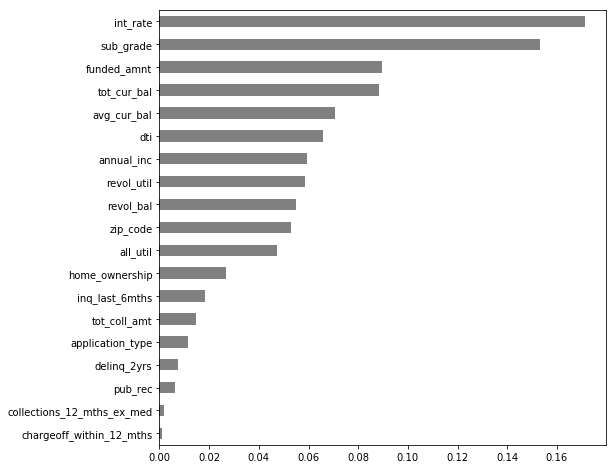

In [19]:
def show_feature_importances(
    pipe, X, y, estimator_name='randomforestclassifier', 
    n=20, figsize=(8, 8)):
    
    # pipe must not change dimensions of X dataframe
    pipe.fit(X, y)
    
    importances = pd.Series(
        pipe.named_steps[estimator_name].feature_importances_, 
        X.columns)

    top_n = importances.sort_values(ascending=False)[:n]
    
    plt.figure(figsize=figsize)
    top_n.sort_values().plot.barh(color='grey')

    
show_feature_importances(pipe, X_train, y_train)

## Show Permutation Importances

In [20]:
encoder = ce.OrdinalEncoder()
X_train_transformed = encoder.fit_transform(X_train)

model = RandomForestClassifier(
    n_estimators=100, 
    class_weight='balanced', 
    min_samples_leaf=0.005, 
    n_jobs=-1)

model.fit(X_train_transformed, y_train)
permuter = PermutationImportance(model, scoring='roc_auc', n_iter=1, cv='prefit')
permuter.fit(X_train_transformed, y_train)

PermutationImportance(cv='prefit',
           estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=0.005,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False),
           n_iter=1, random_state=None, refit=True, scoring='roc_auc')

In [21]:
eli5.show_weights(permuter, top=None, feature_names=X_train_transformed.columns.tolist())

Weight,Feature
0.0482 ± 0.0000,sub_grade
0.0325 ± 0.0000,funded_amnt
0.0297 ± 0.0000,int_rate
0.0173 ± 0.0000,tot_cur_bal
0.0110 ± 0.0000,avg_cur_bal
0.0100 ± 0.0000,home_ownership
0.0099 ± 0.0000,dti
0.0083 ± 0.0000,revol_util
0.0069 ± 0.0000,annual_inc
0.0064 ± 0.0000,revol_bal


## Let's try it another way - using Column Transformer

In [27]:
numeric_features = ['funded_amnt', 'int_rate', 'sub_grade', 'annual_inc', 'delinq_2yrs', 
                    'all_util', 'avg_cur_bal', 'chargeoff_within_12_mths',
                    'collections_12_mths_ex_med', 'dti', 'zip_code', 'inq_last_6mths',
                    'pub_rec', 'revol_bal', 'revol_util', 'tot_coll_amt', 'tot_cur_bal',
                   ]
categorical_features = ['application_type', 'home_ownership']

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('onehotencoder', OneHotEncoder())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
   ('cat', categorical_transformer, categorical_features)
])

clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

param_grid = {
    'classifier__n_estimators': [500],
    'classifier__max_depth': [5, 10, 15, 20, 25, 30],
    'classifier__oob_score': [True],
}

grid_search = GridSearchCV(clf, param_grid, n_jobs=-1, cv = 5, 
                           scoring='roc_auc')
grid_search.fit(X_train, y_train)
print('  Best score from grid search:', grid_search.score(X_test, y_test))

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


  Best score from grid search: 0.7434245124778729


## Show Feature Importances

In [28]:
# Having a hard time figuring out how to get feature importances
# from a grid search where a Column Transformer is used.
# I don't think this is possible, since I've not seen anyone 
# give a solution. With gridsearchcv, you can do:
# grid_search.best_estimator_.named_steps['classifier'].feature_importances_
# but this does not work.

# importances = pd.Series(
#     # grid_search.best_estimator_.named_steps['classifier'].feature_importances_, 
#     clf.steps[1][1].feature_importances_,
#     X.columns)

# top_n = importances.sort_values(ascending=False)[:20]

# plt.figure(figsize=(8, 8))
# top_n.sort_values().plot.barh(color='green')

## Let's try XGBoost Classifier

In [22]:
pipe = make_pipeline(ce.OrdinalEncoder(),
                     XGBClassifier())
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.8577295005961054

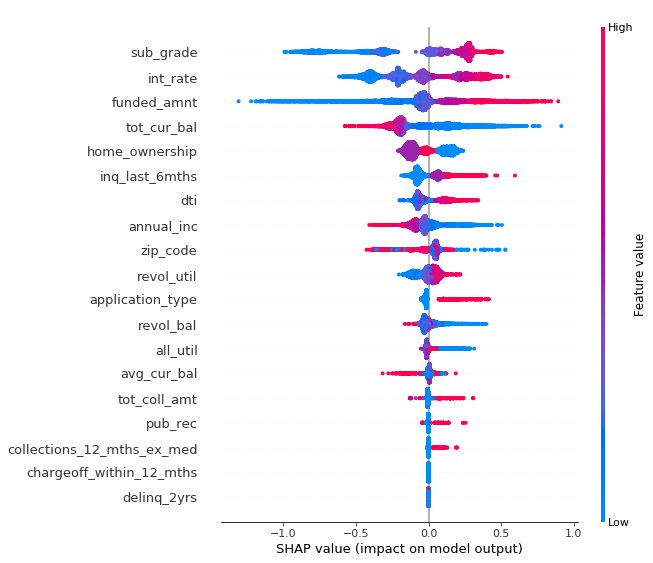

In [23]:
shap.initjs()

# pipeline is not supported by TreeExplainer,
# so we have to do this
encoder = ce.OrdinalEncoder()
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)
xgb = XGBClassifier()
model = xgb.fit(X_train, y_train)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

### Create prediction against the test set

In [24]:
X_test = pd.read_csv('./test_features.csv', header=0)
X_test.head()

,id,member_id,loan_amnt,funded_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,annual_inc_joint,dti_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,disbursement_method
0,57146,NaN,18500,18500,60 months,25.82%,551.93,E,E4,Account Service Representative,10+ years,MORTGAGE,87000.0,NaN,NaN,debt_consolidation,Debt consolidation,452xx,OH,22.07,0,Jun-2007,3,NaN,111.0,20,1,5504,16.9%,37,w,0,NaN,Individual,NaN,NaN,0,200,212122,2,5,4,6,1.0,105151,88.0,2,3,2991,66.0,32500,6,3,12,10,10606.0,16813.0,23.9,0,0,127.0,55,7,1,2,8.0,NaN,1.0,NaN,0,4,5,8,9,20,14,15,5,20,0.0,0,0,6,100.0,0.0,1,0,250214,110655,22100,113624,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash
1,20988,NaN,36000,36000,60 months,12.61%,811.95,C,C1,Vice President of IT,7 years,MORTGAGE,165000.0,NaN,NaN,other,Other,480xx,MI,13.39,0,Oct-1992,0,31.0,NaN,12,0,21833,42.6%,21,w,0,NaN,Individual,NaN,NaN,0,0,42059,2,2,1,2,6.0,20226,56.0,1,3,5880,48.0,51200,1,0,1,5,3505.0,19340.0,41.4,0,0,304.0,131,4,4,0,15.0,31.0,6.0,31.0,0,3,7,6,6,6,10,14,7,12,0.0,0,0,2,85.7,16.7,0,0,87584,42059,33000,36384,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash
2,10031,NaN,12000,12000,36 months,22.90%,463.90,E,E1,Director of Technology,4 years,MORTGAGE,110000.0,NaN,NaN,debt_consolidation,Debt consolidation,972xx,OR,15.82,1,Dec-2004,0,7.0,NaN,4,0,19930,97.2%,11,f,0,NaN,Individual,NaN,NaN,0,0,170912,0,1,1,1,8.0,25739,86.0,0,0,10385,90.0,20500,0,0,0,1,42728.0,570.0,97.2,0,0,130.0,162,42,8,2,42.0,NaN,19.0,NaN,0,2,2,2,3,4,2,5,2,4,0.0,0,0,1,81.8,100.0,0,0,210150,45669,20500,30000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash
3,33892,NaN,24875,24875,60 months,11.98%,553.08,B,B5,vp,10+ years,MORTGAGE,105000.0,NaN,NaN,other,Other,463xx,IN,6.91,0,Nov-1995,1,NaN,NaN,7,0,29537,47.3%,24,w,0,NaN,Individual,NaN,NaN,0,0,507349,0,0,0,1,18.0,0,NaN,0,1,12097,47.0,62400,1,1,2,3,84558.0,27863.0,51.5,0,0,126.0,268,22,15,3,65.0,NaN,4.0,NaN,0,4,4,5,7,9,6,12,4,7,0.0,0,0,0,100.0,25.0,0,0,547400,29537,57400,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash
4,35374,NaN,4000,4000,36 months,10.91%,130.79,B,B4,Sales consultant,< 1 year,MORTGAGE,20000.0,NaN,NaN,other,Other,705xx,LA,69.96,0,Sep-2003,0,NaN,NaN,16,0,5863,18.8%,28,w,0,NaN,Joint App,66000.0,32.72,0,0,169662,1,2,1,2,10.0,43585,85.0,0,4,1013,46.0,31200,10,2,5,7,10604.0,4533.0,37.9,0,0,159.0,53,19,2,2,22.0,NaN,4.0,NaN,0,6,10,6,7,12,13,14,10,16,0.0,0,0,2,100.0,0.0,0,0,209852,49448,7300,58652,6169.0,Sep-2003,0.0,2.0,7.0,22.9,3.0,3.0,0.0,0.0,NaN,Cash


In [27]:
df2 = X_test.loc[:, use_columns].copy()
df2.head()

/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,funded_amnt,int_rate,sub_grade,annual_inc,delinq_2yrs,all_util,avg_cur_bal,chargeoff_within_12_mths,collections_12_mths_ex_med,dti,application_type,home_ownership,zip_code,inq_last_6mths,pub_rec,revol_bal,revol_util,tot_coll_amt,tot_cur_bal,charged_off
0,18500,25.82%,E4,87000.0,0,66.0,10606.0,0,0,22.07,Individual,MORTGAGE,452xx,3,1,5504,16.9%,200,212122,NaN
1,36000,12.61%,C1,165000.0,0,48.0,3505.0,0,0,13.39,Individual,MORTGAGE,480xx,0,0,21833,42.6%,0,42059,NaN
2,12000,22.90%,E1,110000.0,1,90.0,42728.0,0,0,15.82,Individual,MORTGAGE,972xx,0,0,19930,97.2%,0,170912,NaN
3,24875,11.98%,B5,105000.0,0,47.0,84558.0,0,0,6.91,Individual,MORTGAGE,463xx,1,0,29537,47.3%,0,507349,NaN
4,4000,10.91%,B4,20000.0,0,46.0,10604.0,0,0,69.96,Joint App,MORTGAGE,705xx,0,0,5863,18.8%,0,169662,NaN


In [29]:
df2 = wrangle(df2.drop('charged_off', axis=1))

In [30]:
df2.shape

(9437, 19)

In [31]:
y_pred = pipe.predict_proba(df2)[:, 1]

In [32]:
df2['id'] = X_test.id

In [33]:
y_pred

array([0.19551404, 0.1784826 , 0.11433356, ..., 0.20028655, 0.2359799 ,
       0.14277701], dtype=float32)

In [34]:
res = pd.DataFrame(data={'id': df2.id.values, 'charged_off': y_pred})
res.head()

,id,charged_off
0,57146,0.195514
1,20988,0.178483
2,10031,0.114334
3,33892,0.083203
4,35374,0.121907


In [35]:
res.to_csv('./y_pred.csv', header=True, index=False)

## 